In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
import seaborn as sns 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
def remove_URL(text):
    return re.sub(r"http\S+", "", text)

def remove_ahref(text):
    return re.sub("<a href([\w\-\s]+\/)*", '', text)

def remove_HTML(text):
    return re.sub('<.*?>', '', text)

def complex_split(text):
    return re.split(r'\s|-|\*|\.\.\.\.\.\.\.\.\.\.\.\.\.|\.\.\.\.|\.\.\.', text)

def split_for_essay5(text):
    return re.split(r'\s|-|\*|,|\.|\/', text)

def comma_split(text):
    return re.split(',', text)

def dot_split(text):
    return re.split('\.', text)

def slash_split(text):
    return re.split('/', text)

In [3]:
profiles = pd.read_csv('profiles.csv')
print(profiles.info())
#59946 rows, 31 columns

''' So far I have predicted:
1. Education level based on essay avg word lengths, age, sex, drinking/drugs/smoking (KNN and SVM)
2. Sex and/or Orientation from content of essays 0, 1, 3, and 5
3. predict age based on sex, age, avg. words in all essays considered (this is your regressions one)
4. k++Means looking for "optimal" number of clusters in the data
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   body_type    54650 non-null  object 
 2   diet         35551 non-null  object 
 3   drinks       56961 non-null  object 
 4   drugs        45866 non-null  object 
 5   education    53318 non-null  object 
 6   essay0       54458 non-null  object 
 7   essay1       52374 non-null  object 
 8   essay2       50308 non-null  object 
 9   essay3       48470 non-null  object 
 10  essay4       49409 non-null  object 
 11  essay5       49096 non-null  object 
 12  essay6       46175 non-null  object 
 13  essay7       47495 non-null  object 
 14  essay8       40721 non-null  object 
 15  essay9       47343 non-null  object 
 16  ethnicity    54266 non-null  object 
 17  height       59943 non-null  float64
 18  income       59946 non-null  int64  
 19  job 

' So far I have predicted:\n1. Education level based on essay avg word lengths, age, sex, drinking/drugs/smoking (KNN and SVM)\n2. Sex and/or Orientation from content of essays 0, 1, 3, and 5\n3. predict age based on sex, age, avg. words in all essays considered (this is your regressions one)\n4. k++Means looking for "optimal" number of clusters in the data\n'

In [ ]:
print(profiles.drinks.unique())

In [6]:
print(profiles.drugs.unique())
print(profiles.drugs.value_counts())

['never' 'sometimes' nan 'often']
never        37724
sometimes     7732
often          410
Name: drugs, dtype: int64


In [ ]:
print(profiles.smokes.unique())

In [ ]:
print(profiles.offspring.value_counts())

In [62]:
print(profiles.status.value_counts())
print(profiles.status.value_counts()/59946.0)

single            55697
seeing someone     2064
available          1865
married             310
unknown              10
Name: status, dtype: int64
single            0.929120
seeing someone    0.034431
available         0.031111
married           0.005171
unknown           0.000167
Name: status, dtype: float64


In [55]:
print(profiles.orientation.value_counts())
print(profiles.orientation.value_counts()/59946.0)

straight    51606
gay          5573
bisexual     2767
Name: orientation, dtype: int64
straight    0.860875
gay         0.092967
bisexual    0.046158
Name: orientation, dtype: float64


In [ ]:
print(profiles.diet.value_counts())

In [56]:
print(profiles.sex.value_counts()/59946.0)
print(profiles.sex.value_counts()/59946.0)

m    0.597688
f    0.402312
Name: sex, dtype: float64
m    0.597688
f    0.402312
Name: sex, dtype: float64


In [5]:
print(profiles.education.value_counts())
print(profiles.education.nunique())

graduated from college/university    23959
graduated from masters program        8961
working on college/university         5712
working on masters program            1683
graduated from two-year college       1531
graduated from high school            1428
graduated from ph.d program           1272
graduated from law school             1122
working on two-year college           1074
dropped out of college/university      995
working on ph.d program                983
college/university                     801
graduated from space camp              657
dropped out of space camp              523
graduated from med school              446
working on space camp                  445
working on law school                  269
two-year college                       222
working on med school                  212
dropped out of two-year college        191
dropped out of masters program         140
masters program                        136
dropped out of ph.d program            127
dropped out

In [ ]:
print(profiles.job.value_counts())

In [230]:
print(min(profiles.age), max(profiles.age))

18 110


Text(0.5, 1.0, 'Distribution of Ages Reported in OKCupid Profiles')

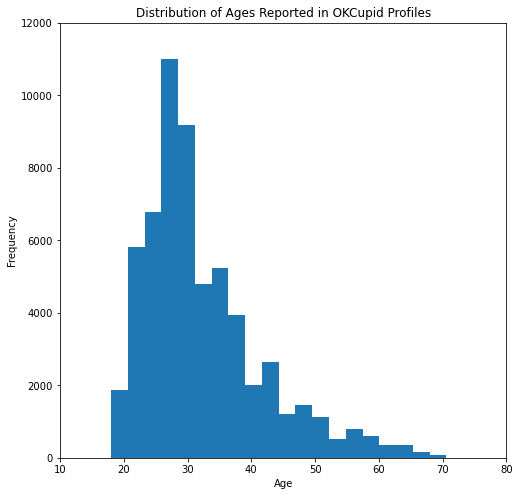

In [5]:
plt.figure(figsize=(8,8))
plt.hist(profiles.age, bins = 35)
plt.axis([10,80,0,12000])
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Ages Reported in OKCupid Profiles')

In [ ]:
print(min(profiles.income), max(profiles.income))
# Assume -1 means no answer. 
no_income_answer = profiles.income[profiles.income == -1]
print(len(no_income_answer))
income_answer = profiles.income[profiles.income > 0]
print(len(income_answer))

In [6]:
profiles["drinks_num_scale"] = profiles.drinks.map({"not at all": 0, "rarely": 1, "socially": 2, "often": 3, \
                                                   "very often": 4, "desperately": 5})
profiles["drugs_num_scale"] = profiles.drugs.map({"never": 0, "sometimes": 1, "often": 2})
profiles["smokes_num_scale"] = profiles.smokes.map({"no": 0, "when drinking": 1, "sometimes": 2, "trying to quit": 3, \
                                                   "yes": 4})
profiles["sex_binary"] = profiles.sex.map({"m": 0, "f": 1})

The cell below contains a whole lot of code as I attempt to clean the text of essay0 in an attempt to find the average word length per profile. Oddly enough, when you let the general public write whatever they want in a profile and format that profile however they want, people are going to do some off-the-wall things. I've waded through a few off-the-wall things, but I do not claim to have found every off-the-wall thing in this list of essays.

In [7]:
# Removing the NaNs:
profiles['Temp'] = profiles.essay0.replace(np.nan, '', regex=True)

# Removing HTML links and URLs, because these are not actual words:
profiles.Temp = profiles.Temp.apply(lambda x: remove_HTML(x))
profiles.Temp = profiles.Temp.apply(lambda x: remove_URL(x))

# Replacing some HTML characters:
profiles.Temp = profiles.Temp.replace('\&nbsp', ' ', regex = True)
profiles.Temp = profiles.Temp.replace('\n', ' ', regex = True)

# These essays did not contain any actual words, so they are being set to an empty list:
profiles.at[52025,'Temp'] = ''
profiles.at[31734,'Temp'] = ''
profiles.at[14392,'Temp'] = ''
profiles.at[45430,'Temp'] = ''
profiles.at[23818,'Temp'] = ''
profiles.at[32779,'Temp'] = ''
profiles.at[17064,'Temp'] = ''

# Make all characters lowercase, if they aren't already:
profiles.Temp = profiles.Temp.apply(lambda x: x.lower())

# Split the text by single space, dash, or more complicated structures I found in certain profiles:
essay0_words_list = profiles.Temp.apply(lambda x: complex_split(x))

# Get the total number of characters in the essay:
profiles["essay0_length"] = profiles.Temp.apply(lambda x: len(x))

# Add some columns to the profiles DataFrame which will ultimately contain some useful information but
# are now being initialized at zero:
profiles["essay0_avg_word_length"]= 0.0

# Begin with a loop over all lists in the essay0_words_list as defined above. For one profile, remove the last 
# element in the list as it is a decorative (very long) string of characters. Then, loop over words/groups of 
# letters in actual list of words. For some profiles, split the single string in that list by backslash, comma, 
# or period. Count the length of each word/group of letters as you go. Count the number of times "I", "me", and
# "you" appear in the list of words/groups of letters. Finally, find the average length of a word/group of letters
# in the words list.

for i in range(len(essay0_words_list)):
    thislist = essay0_words_list[i]    
    if i == 17369:
        thislist[-1] = ''
    thiswordcountlist = []
    for word in thislist:
        if i == 17622:
            real_words = dot_split(word)
            essay0_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))  
        if i == 14195:
            real_words = dot_split(word)
            essay0_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))  
        if i == 59770:
            real_words = slash_split(word)
            essay0_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 9989:
            real_words = slash_split(word)
            essay0_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 11548:
            real_words = slash_split(word)
            essay0_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))  
        if i == 53550:
            real_words = slash_split(word)
            essay0_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))  
        if i == 50906:
            real_words = slash_split(word)
            essay0_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))  
        if i == 28651:
            real_words = comma_split(word)
            essay0_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        else:
            thiswordcountlist.append(len(word))
    avgwordcount = np.mean(thiswordcountlist)
    profiles.at[i,'essay0_avg_word_length'] = avgwordcount
    
#print(profiles.essay0_avg_word_length)
print(np.mean(profiles.essay0_avg_word_length))
#zero_words = profiles.essay0_avg_word_length[profiles.essay0_avg_word_length == 0.0]
#print(len(zero_words), 59946-54458)

#print(min(profiles.essay0_avg_word_length), max(profiles.essay0_avg_word_length))
#problemchild = essay0_words_list[profiles.essay0_avg_word_length == max(profiles.essay0_avg_word_length)]
#print(problemchild)

4.004998935237513


In [8]:
# Removing the NaNs
profiles['Temp'] = profiles.essay1.replace(np.nan, '', regex=True)

# Removing HTML links and URLs, because these are not actual words:
profiles.Temp = profiles.Temp.apply(lambda x: remove_HTML(x))
profiles.Temp = profiles.Temp.apply(lambda x: remove_URL(x))

# Replacing some HTML characters:
profiles.Temp = profiles.Temp.replace('\&nbsp', ' ', regex = True)
profiles.Temp = profiles.Temp.replace('\n', ' ', regex = True)

# This essay did not contain any actual words, so they are being set to an empty list:
profiles.at[31734,'Temp'] = ''

# Make all characters lowercase, if they aren't already:
profiles.Temp = profiles.Temp.apply(lambda x: x.lower())

# Split the text by single space, dash, or more complicated structures I found in certain profiles:
essay1_words_list = profiles.Temp.apply(lambda x: complex_split(x))

# Get the total number of characters in the essay:
profiles["essay1_length"] = profiles.Temp.apply(lambda x: len(x))

# Add some columns to the profiles DataFrame which will ultimately contain some useful information but
# are now being initialized at zero:
profiles["essay1_avg_word_length"]= 0.0


# Begin with a loop over all lists in the essay0_words_list as defined above. For one profile, remove the last 
# element in the list as it is a decorative (very long) string of characters. Then, loop over words/groups of 
# letters in actual list of words. For some profiles, split the single string in that list by backslash, comma, 
# or period. Count the length of each word/group of letters as you go. Count the number of times "I", "me", and
# "you" appear in the list of words/groups of letters. Finally, find the average length of a word/group of letters
# in the words list.

for i in range(len(essay1_words_list)):
    thislist = essay1_words_list[i]
    if i == 31521:
        thislist[-1] = ''
    thiswordcountlist = []
    for word in thislist:
        if i == 17622:
            real_words = dot_split(word)
            essay1_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 40493:
            real_words = dot_split(word)
            essay1_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 8753:
            real_words = dot_split(word)
            essay1_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 44425:
            real_words = slash_split(word)
            essay1_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 40506:
            real_words = comma_split(word)
            essay1_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        else:
            thiswordcountlist.append(len(word))
    avgwordcount = np.mean(thiswordcountlist)
    profiles.at[i,'essay1_avg_word_length'] = avgwordcount

#print(profiles.essay1_avg_word_length)
print(np.mean(profiles.essay1_avg_word_length))
#zero_words = profiles.essay1_avg_word_length[profiles.essay1_avg_word_length == 0.0]
#print(len(zero_words), 59946-52374)

#print(min(profiles.essay1_avg_word_length), max(profiles.essay1_avg_word_length))
#problemchild = essay1_words_list[profiles.essay1_avg_word_length == max(profiles.essay1_avg_word_length)]
#print(problemchild)

4.048505765820338


In [9]:
# Removing the NaNs
profiles['Temp'] = profiles.essay2.replace(np.nan, '', regex=True)

# Removing HTML links and URLs, because these are not actual words:
profiles.Temp = profiles.Temp.apply(lambda x: remove_HTML(x))
profiles.Temp = profiles.Temp.apply(lambda x: remove_URL(x))

# Replacing some HTML characters:
profiles.Temp = profiles.Temp.replace('\&nbsp', ' ', regex = True)
profiles.Temp = profiles.Temp.replace('\n', ' ', regex = True)

# These essays did not contain any actual words, so they are being set to an empty list:
profiles.at[31734,'Temp'] = ''
profiles.at[2313,'Temp'] = ''

# Make all characters lowercase, if they aren't already:
profiles.Temp = profiles.Temp.apply(lambda x: x.lower())

# Split the text by single space, dash, or more complicated structures I found in certain profiles:
essay2_words_list = profiles.Temp.apply(lambda x: complex_split(x))

# Get the total number of characters in the essay:
profiles["essay2_length"] = profiles.Temp.apply(lambda x: len(x))

# Add some columns to the profiles DataFrame which will ultimately contain some useful information but
# are now being initialized at zero:
profiles["essay2_avg_word_length"]= 0.0


# Begin with a loop over all lists in the essay0_words_list as defined above. For one profile, remove the last 
# element in the list as it is a decorative (very long) string of characters. Then, loop over words/groups of 
# letters in actual list of words. For some profiles, split the single string in that list by backslash, comma, 
# or period. Count the length of each word/group of letters as you go. Count the number of times "I", "me", and
# "you" appear in the list of words/groups of letters. Finally, find the average length of a word/group of letters
# in the words list.

for i in range(len(essay2_words_list)):
    thislist = essay2_words_list[i]
    if i == 31521:
        thislist[-1] = ''
    if i == 33421:
        thislist[-1] = ''
    thiswordcountlist = []
    for word in thislist:
        if i == 47383:
            real_words = comma_split(word)
            essay2_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 34961:
            real_words = comma_split(word)
            essay2_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 14097:
            real_words = comma_split(word)
            essay2_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 59768:
            real_words = comma_split(word)
            essay2_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 5286:
            real_words = comma_split(word)
            essay2_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 11702:
            real_words = comma_split(word)
            essay2_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 46259:
            real_words = comma_split(word)
            essay2_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))  
        if i == 49255:
            real_words = comma_split(word)
            essay2_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))  
        if i == 23295:
            real_words = slash_split(word)
            essay2_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 4662:
            real_words = slash_split(word)
            essay2_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 19199:
            real_words = slash_split(word)
            essay2_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 49633:
            real_words = dot_split(word)
            essay2_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        else:
            thiswordcountlist.append(len(word))
    avgwordcount = np.mean(thiswordcountlist)
    profiles.at[i,'essay2_avg_word_length'] = avgwordcount

#print(profiles.essay2_avg_word_length)
print(np.mean(profiles.essay2_avg_word_length))
#zero_words = profiles.essay2_avg_word_length[profiles.essay2_avg_word_length == 0.0]
#print(len(zero_words), 59946-50308)

#print(min(profiles.essay2_avg_word_length), max(profiles.essay2_avg_word_length))
#problemchild = essay2_words_list[profiles.essay2_avg_word_length == max(profiles.essay2_avg_word_length)]
#print(problemchild)

4.50666324076322


In [10]:
# Removing the NaNs
profiles['Temp'] = profiles.essay5.replace(np.nan, '', regex=True)
profiles.Temp = profiles.Temp.apply(lambda x: remove_HTML(x))
profiles.Temp = profiles.Temp.apply(lambda x: remove_URL(x))
profiles.Temp = profiles.Temp.replace('\&nbsp', ' ', regex = True)
profiles.Temp = profiles.Temp.replace('\&lt;', ' ', regex = True)
profiles.Temp = profiles.Temp.replace('\&gt;', ' ', regex = True)
profiles.Temp = profiles.Temp.replace('\n', ' ', regex = True)

# The below essay was nothing but "mycomputer" repeated over and over again, without spaces inbetween, until the 
# user ran out of characters. So, I am keeping the main idea behind their essay.
profiles.at[23872,'Temp'] = 'mycomputer'

profiles.Temp = profiles.Temp.apply(lambda x: x.lower())

essay5_words_list = profiles.Temp.apply(lambda x: split_for_essay5(x))

profiles["essay5_length"] = profiles.Temp.apply(lambda x: len(x))

profiles["essay5_avg_word_length"]= 0.0

for i in range(len(essay5_words_list)):
    thislist = essay5_words_list[i]
    thiswordcountlist = []
    if i == 7692:
        thislist[-1] = ''
    for word in thislist:
        if i == 43309:
            real_words = word.split(')')
            essay5_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 11783:
            real_words = word.split('+')
            essay5_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))  
        if i == 2900:
            real_words = word.split('~')
            essay5_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))  
        if i == 6623:
            real_words = word.split('\.\.')
            essay5_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        else:
            thiswordcountlist.append(len(word))
    avgwordcount = np.mean(thiswordcountlist)
    profiles.at[i,'essay5_avg_word_length'] = avgwordcount

#print(profiles.essay5_avg_word_length)
print(np.mean(profiles.essay5_avg_word_length))
#zero_words = profiles.essay5_avg_word_length[profiles.essay5_avg_word_length == 0.0]
#print(len(zero_words), 59946-49096)

#print(min(profiles.essay5_avg_word_length), max(profiles.essay5_avg_word_length))
#problemchild = essay5_words_list[profiles.essay5_avg_word_length == max(profiles.essay5_avg_word_length)]
#print(problemchild)

3.231602061752812


In [11]:
# Removing the NaNs
profiles['Temp'] = profiles.essay6.replace(np.nan, '', regex=True)
profiles.Temp = profiles.Temp.apply(lambda x: remove_HTML(x))
profiles.Temp = profiles.Temp.apply(lambda x: remove_URL(x))
profiles.Temp = profiles.Temp.replace('\&nbsp', ' ', regex = True)
profiles.Temp = profiles.Temp.replace('\n', ' ', regex = True)

profiles.at[44806,'Temp'] = 'mycomputer'
profiles.at[42462,'Temp'] = 'science'

profiles.Temp = profiles.Temp.apply(lambda x: x.lower())

essay6_words_list = profiles.Temp.apply(lambda x: complex_split(x))

profiles["essay6_length"] = profiles.Temp.apply(lambda x: len(x))

profiles["essay6_avg_word_length"]= 0.0

for i in range(len(essay6_words_list)):
    thislist = essay6_words_list[i]
    thiswordcountlist = []
    for word in thislist:
        if i == 39099:
            real_words = comma_split(word)
            essay6_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 42814:
            real_words = slash_split(word)
            essay6_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 31942:
            real_words = slash_split(word)
            essay6_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        if i == 36804:
            real_words = word.split('=')
            essay6_words_list[i] = real_words
            for wd in real_words:
                thiswordcountlist.append(len(wd))
        else:
            thiswordcountlist.append(len(word))
    avgwordcount = np.mean(thiswordcountlist)
    profiles.at[i,'essay6_avg_word_length'] = avgwordcount


#print(profiles.essay6_avg_word_length)
print(np.mean(profiles.essay6_avg_word_length))
#zero_words = profiles.essay6_avg_word_length[profiles.essay6_avg_word_length == 0.0]
#print(len(zero_words), 59946-46175)

#print(min(profiles.essay6_avg_word_length), max(profiles.essay6_avg_word_length))
#problemchild = essay6_words_list[profiles.essay6_avg_word_length == max(profiles.essay6_avg_word_length)]
#print(problemchild)

3.551806020985369


In [12]:
profiles.drop(columns = ['Temp'], inplace = True)

In [13]:
print(profiles.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     59946 non-null  int64  
 1   body_type               54650 non-null  object 
 2   diet                    35551 non-null  object 
 3   drinks                  56961 non-null  object 
 4   drugs                   45866 non-null  object 
 5   education               53318 non-null  object 
 6   essay0                  54458 non-null  object 
 7   essay1                  52374 non-null  object 
 8   essay2                  50308 non-null  object 
 9   essay3                  48470 non-null  object 
 10  essay4                  49409 non-null  object 
 11  essay5                  49096 non-null  object 
 12  essay6                  46175 non-null  object 
 13  essay7                  47495 non-null  object 
 14  essay8                  40721 non-null

In [14]:
alldata = profiles[['age','sex','sex_binary','orientation','status','offspring', 
                    'drinks_num_scale','drugs_num_scale','smokes_num_scale', \
                    'education','income','job', \
                    'essay0_length', 'essay0_avg_word_length', 
                    'essay1_length', 'essay1_avg_word_length',
                    'essay2_length', 'essay2_avg_word_length',
                    'essay5_length', 'essay5_avg_word_length',
                    'essay6_length', 'essay6_avg_word_length']]

<h1> Predicting education based on various numerical columns </h1>

In [15]:
question_1_data = alldata.dropna(subset = ['age','sex_binary','drinks_num_scale','drugs_num_scale','smokes_num_scale',\
                                           'essay0_avg_word_length', 'essay1_avg_word_length', 'essay2_avg_word_length', \
                                           'essay6_avg_word_length', 'education'])

question_1_data = question_1_data[question_1_data.essay0_avg_word_length != 0.0]
question_1_data = question_1_data[question_1_data.essay1_avg_word_length != 0.0]
question_1_data = question_1_data[question_1_data.essay2_avg_word_length != 0.0]
question_1_data = question_1_data[question_1_data.essay6_avg_word_length != 0.0]

predict_ed_data = question_1_data[['age','sex_binary','drinks_num_scale','drugs_num_scale','smokes_num_scale',\
                                   'essay0_avg_word_length', 'essay1_avg_word_length', \
                                   'essay2_avg_word_length', 'essay6_avg_word_length']]
predict_ed_labels = question_1_data['education']

In [16]:
feat_train_q1, feat_test_q1, labels_train_q1, labels_test_q1 =  \
      train_test_split(predict_ed_data, predict_ed_labels, train_size = 0.70, test_size = 0.3, random_state = 21)

In [17]:
stdscale1 = StandardScaler()
scaled_feat_train_q1 = stdscale1.fit_transform(feat_train_q1)
scaled_feat_test_q1 = stdscale1.transform(feat_test_q1)

In [ ]:
scores_knn_q1 = []

for k in range(1,2001):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(scaled_feat_train_q1, labels_train_q1)
    scores_knn_q1.append(classifier.score(scaled_feat_test_q1, labels_test_q1))
    
print(scores_knn_q1.index(max(scores_knn_q1))+1)

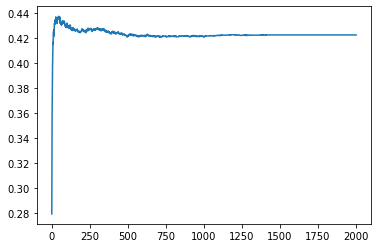

In [30]:
plt.plot(range(1,2001),scores_knn_q1)

In [31]:
knn_classifier = KNeighborsClassifier(n_neighbors = scores_knn_q1.index(max(scores_knn_q1))+1)
knn_classifier.fit(scaled_feat_train_q1, labels_train_q1)

knn_labels_predictions = knn_classifier.predict(scaled_feat_test_q1)
knn_classifier_score = knn_classifier.score(scaled_feat_test_q1, labels_test_q1)
print(knn_classifier_score)

0.43722707423580787


In [32]:
scores = []
gees = []
cees = []

for g in range(1,5):
    for c in range(1,10):
        c = c / 10.0
        classes = SVC(kernel = 'rbf', gamma = g, C = c)
        classes.fit(scaled_feat_train_q1, labels_train_q1)
        scores.append(classes.score(scaled_feat_test_q1,labels_test_q1))
        gees.append(g)
        cees.append(c)

In [33]:
print(scores.index(max(scores)), max(scores))
print(gees[6])
print(cees[6])

6 0.4423216885007278
1
0.7


In [34]:
svm_classifier = SVC(kernel = 'rbf', gamma = 1, C = 0.7)
svm_classifier.fit(scaled_feat_train_q1, labels_train_q1)
print(svm_classifier.score(scaled_feat_test_q1,labels_test_q1))

0.4423216885007278


<h1> Predicting Sex and/or Orientation from essays using Naive Bayes </h1>

In [35]:
nb_data = profiles.dropna(subset = ['essay0','essay1', 'essay3', 'essay5'])
master_essay_list = nb_data.essay0 + nb_data.essay1 + nb_data.essay3 + nb_data.essay5
master_sexes_list = nb_data.sex + nb_data.sex + nb_data.sex + nb_data.sex
master_orientation_list = nb_data.orientation + nb_data.orientation + nb_data.orientation + nb_data.orientation

print(len(master_essay_list), len(master_sexes_list), len(master_orientation_list))

41548 41548 41548


In [36]:
nb1_train_data, nb1_test_data, nb1_train_labels, nb1_test_labels = \
train_test_split(master_essay_list, master_sexes_list,train_size = 0.8, test_size = 0.2, random_state = 21)

counter1 = CountVectorizer()
counter1.fit(nb1_train_data)
nb1_train_counts = counter1.transform(nb1_train_data)
nb1_test_counts = counter1.transform(nb1_test_data)

nb1_classifier = MultinomialNB()
nb1_classifier.fit(nb1_train_counts, nb1_train_labels)
nb1_predictions = nb1_classifier.predict(nb1_test_counts)

In [37]:
print(accuracy_score(nb1_test_labels, nb1_predictions))
print(confusion_matrix(nb1_test_labels, nb1_predictions))

0.7495788206979542
[[2551  837]
 [1244 3678]]


In [38]:
nb2_train_data, nb2_test_data, nb2_train_labels, nb2_test_labels = \
train_test_split(master_essay_list, master_orientation_list, train_size = 0.8, test_size = 0.2, random_state = 21)

counter2 = CountVectorizer()
counter2.fit(nb2_train_data)
nb2_train_counts = counter2.transform(nb2_train_data)
nb2_test_counts = counter2.transform(nb2_test_data)

nb2_classifier = MultinomialNB()
nb2_classifier.fit(nb2_train_counts, nb2_train_labels)
nb2_predictions = nb2_classifier.predict(nb2_test_counts)

In [40]:
print(accuracy_score(nb2_test_labels, nb2_predictions))
print(confusion_matrix(nb2_test_labels, nb2_predictions))

0.8345367027677497
[[  49    9  368]
 [  32   31  809]
 [ 124   33 6855]]


<h1> Decision Tree something something or Logistic Regression something something </h1>

In [39]:
question_3_data = alldata.dropna(subset = ['job'])

question_3_data = question_3_data[question_3_data.essay0_length != 0]
question_3_data = question_3_data[question_3_data.essay1_length != 0]
question_3_data = question_3_data[question_3_data.essay2_length != 0]
question_3_data = question_3_data[question_3_data.essay5_length != 0]
question_3_data = question_3_data[question_3_data.essay6_length != 0]

question_3_data = question_3_data[question_3_data.essay0_avg_word_length != 0.0]
question_3_data = question_3_data[question_3_data.essay1_avg_word_length != 0.0]
question_3_data = question_3_data[question_3_data.essay2_avg_word_length != 0.0]
question_3_data = question_3_data[question_3_data.essay5_avg_word_length != 0.0]
question_3_data = question_3_data[question_3_data.essay6_avg_word_length != 0.0]

forest_data = question_3_data[['essay0_length', 'essay0_avg_word_length', 
                               'essay1_length', 'essay1_avg_word_length',
                               'essay2_length', 'essay2_avg_word_length',
                               'essay5_length', 'essay5_avg_word_length',
                               'essay6_length', 'essay6_avg_word_length']]

forest_labels = question_3_data['job']

In [40]:
feat_train_q3, feat_test_q3, class_train_q3, class_test_q3 =  \
      train_test_split(forest_data, forest_labels, train_size = 0.8, test_size = 0.2, random_state = 21)

single_tree = DecisionTreeClassifier(random_state = 21)
forest = RandomForestClassifier(n_estimators = 200, random_state = 21)

single_tree.fit(feat_train_q3, class_train_q3)
forest.fit(feat_train_q3, class_train_q3)

single_tree_predictions = single_tree.predict(feat_test_q3)
forest_predictions=forest.predict(feat_test_q3)

print(single_tree.score(feat_test_q3, class_test_q3))
print(forest.score(feat_test_q3, class_test_q3))

0.08487763474324515
0.12774084028858396


In [41]:
question_4_data = alldata.dropna(subset = ['drinks_num_scale','drugs_num_scale','smokes_num_scale'])

question_4_data = question_4_data[question_4_data.essay0_length != 0]
question_4_data = question_4_data[question_4_data.essay1_length != 0]
question_4_data = question_4_data[question_4_data.essay5_length != 0]
question_4_data = question_4_data[question_4_data.essay0_avg_word_length != 0.0]
question_4_data = question_4_data[question_4_data.essay1_avg_word_length != 0.0]
question_4_data = question_4_data[question_4_data.essay5_avg_word_length != 0.0]

logregress_data = question_4_data[['drinks_num_scale','drugs_num_scale','smokes_num_scale', \
                                   'essay0_length', 'essay0_avg_word_length', \
                                   'essay1_length', 'essay1_avg_word_length', \
                                   'essay5_length', 'essay5_avg_word_length']]

logregress_labels = question_4_data['sex_binary']

feat_train_q4, feat_test_q4, class_train_q4, class_test_q4 =  \
      train_test_split(logregress_data, logregress_labels, train_size = 0.8, test_size = 0.2, random_state = 3)

In [42]:
stdscaleq4 = StandardScaler()
scaled_feat_train_q4 = stdscaleq4.fit_transform(feat_train_q4)
scaled_feat_test_q4 = stdscaleq4.transform(feat_test_q4)

logregress_q4 = LogisticRegression(max_iter = 300)
logregress_q4.fit(scaled_feat_train_q4, class_train_q4)
test_score_q4 = logregress_q4.score(scaled_feat_test_q4, class_test_q4)

print(test_score_q4)

0.5947955390334573


<h1> Finding clusters in the data </h1>

In [46]:
kmeans_data = alldata.dropna(subset = ['age','sex_binary',
                    'drinks_num_scale','drugs_num_scale','smokes_num_scale', \
                    'essay0_length', 'essay0_avg_word_length', 
                    'essay1_length', 'essay1_avg_word_length',
                    'essay2_length', 'essay2_avg_word_length',
                    'essay5_length', 'essay5_avg_word_length',
                    'essay6_length', 'essay6_avg_word_length'])

kmeans_data = kmeans_data[kmeans_data.essay0_length != 0]
kmeans_data = kmeans_data[kmeans_data.essay1_length != 0]
kmeans_data = kmeans_data[kmeans_data.essay2_length != 0]
kmeans_data = kmeans_data[kmeans_data.essay5_length != 0]
kmeans_data = kmeans_data[kmeans_data.essay6_length != 0]

kmeans_data = kmeans_data[kmeans_data.essay0_avg_word_length != 0.0]
kmeans_data = kmeans_data[kmeans_data.essay1_avg_word_length != 0.0]
kmeans_data = kmeans_data[kmeans_data.essay2_avg_word_length != 0.0]
kmeans_data = kmeans_data[kmeans_data.essay5_avg_word_length != 0.0]
kmeans_data = kmeans_data[kmeans_data.essay6_avg_word_length != 0.0]

kmeans_data = kmeans_data[['age','sex_binary',
                    'drinks_num_scale','drugs_num_scale','smokes_num_scale', \
                    'essay0_length', 'essay0_avg_word_length', 
                    'essay1_length', 'essay1_avg_word_length',
                    'essay2_length', 'essay2_avg_word_length',
                    'essay5_length', 'essay5_avg_word_length',
                    'essay6_length', 'essay6_avg_word_length']]

In [49]:
kmeansscale = StandardScaler()
kmeansscale.fit(kmeans_data)
normed_kmeans_data = kmeansscale.transform(kmeans_data)

inertias_kmeans = []

for k in range(1,51):
#for k in range(1,5):
    classifier = KMeans(n_clusters=k, init='k-means++', max_iter=300)
    classifier.fit(normed_kmeans_data)
    inertias_kmeans.append(classifier.inertia_)   

[Text(0, 0, '2'),
 Text(0, 0, '4'),
 Text(0, 0, '6'),
 Text(0, 0, '8'),
 Text(0, 0, '10'),
 Text(0, 0, '12'),
 Text(0, 0, '14'),
 Text(0, 0, '16'),
 Text(0, 0, '18'),
 Text(0, 0, '20'),
 Text(0, 0, '22'),
 Text(0, 0, '24')]

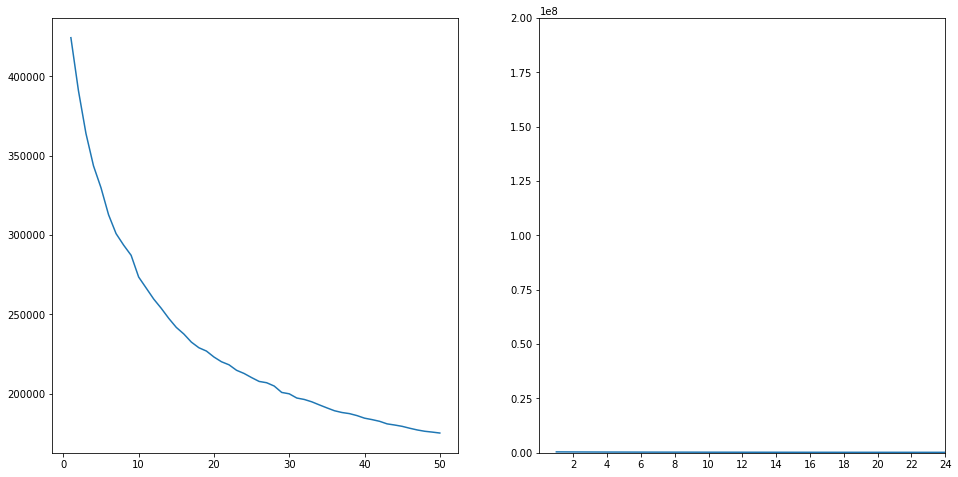

In [50]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(range(1,51),inertias_kmeans)
ax = plt.subplot(1,2,2)
plt.plot(range(1,51),inertias_kmeans)
plt.axis([0,24,0,200000000])
ax.set_xticks([2,4,6,8,10,12,14,16,18,20,22,24])
ax.set_xticklabels([2,4,6,8,10,12,14,16,18,20,22,24])

# Looks like the "elbow" is at 11

<h1> Predicting age based on various numerical data </h1>

In [44]:
# predict age based on drink, drugs, smokes, length of all essays,
# avg. words in all essays considered (this is your regressions one)

question_2_data = alldata.dropna(subset = ['drinks_num_scale','drugs_num_scale','smokes_num_scale','age'])

question_2_data = question_2_data[question_2_data.essay0_length != 0]
#question_2_data = question_2_data[question_2_data.essay0_avg_word_length != 0]
question_2_data = question_2_data[question_2_data.essay1_length != 0.0]
#question_2_data = question_2_data[question_2_data.essay1_avg_word_length != 0]
question_2_data = question_2_data[question_2_data.essay2_length != 0.0]
#question_2_data = question_2_data[question_2_data.essay2_avg_word_length != 0]
question_2_data = question_2_data[question_2_data.essay5_length != 0.0]
#question_2_data = question_2_data[question_2_data.essay5_avg_word_length != 0]
question_2_data = question_2_data[question_2_data.essay6_length != 0.0]
#question_2_data = question_2_data[question_2_data.essay6_avg_word_length != 0]

#plt.scatter(question_2_data['essay0_you_count'], question_2_data['age'])

#print(question_2_data.info())

#predict_income_data = question_2_data[['drinks_num_scale','drugs_num_scale','smokes_num_scale',\
#                                       'essay0_length', 'essay0_avg_word_length', \
#                                       'essay1_length', 'essay1_avg_word_length',\
#                                       'essay2_length', 'essay2_avg_word_length', \
#                                       'essay5_length', 'essay5_avg_word_length', \
#                                       'essay6_length', 'essay6_avg_word_length']]

predict_income_data = question_2_data[['drinks_num_scale','drugs_num_scale','smokes_num_scale',\
                                       'essay0_length',  \
                                       'essay1_length', \
                                       'essay2_length',  \
                                       'essay5_length',  \
                                       'essay6_length', ]]

predict_income = question_2_data['age']

#print(predict_income_data.shape)
#print(predict_income.shape)

In [45]:
feat_train_q2, feat_test_q2, values_train_q2, values_test_q2 =  \
      train_test_split(predict_income_data, predict_income, \
                       train_size = 0.8, test_size = 0.2, random_state = 7)

In [46]:
lin_regress_q2 = LinearRegression()
lin_regress_q2.fit(feat_train_q2, values_train_q2)
lg_q2_predict = lin_regress_q2.predict(feat_test_q2)
print(lin_regress_q2.score(feat_test_q2, values_test_q2))

0.04883196823451297


In [47]:
#stdscale2 = StandardScaler()
stdscale2 = MinMaxScaler()
scaled_feat_train_q2 = stdscale2.fit_transform(feat_train_q2)
scaled_feat_test_q2 = stdscale2.transform(feat_test_q2)

127
-0.19542295512123098


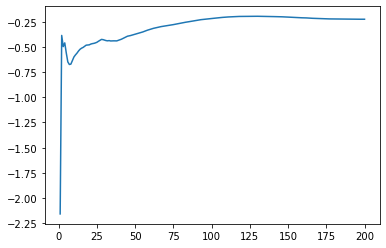

In [48]:
scores_knnr_2 = []

for k in range(1,201):
    regressor = KNeighborsRegressor(n_neighbors = k, weights = 'distance')
    regressor.fit(scaled_feat_train_q2, values_train_q2)
    scores_knnr_2.append(regressor.score(feat_test_q2, values_test_q2))
    
print(scores_knnr_2.index(max(scores_knnr_2))+1)
print(max(scores_knnr_2))
plt.plot(range(1,201),scores_knnr_2)

<h1> Yeah, this probably isn't going anywhere. </h1>

In [182]:
kmeans_classifier_q1 = KMeans(n_clusters=11, init='k-means++', max_iter=300)
kmeans_classifier_q1.fit(predict_ed_data)

KMeans(n_clusters=11)

In [203]:
#print(kmeans_classifier_q1.labels_)
print(min(kmeans_classifier_q1.labels_), max(kmeans_classifier_q1.labels_))

cluster_zero_indices = []
cluster_one_indices = []
cluster_two_indices = []
cluster_three_indices = []
cluster_four_indices = []
cluster_five_indices = []
cluster_six_indices = []
cluster_seven_indices = []
cluster_eight_indices = []
cluster_nine_indices = []
cluster_ten_indices = []

for i in range(len(kmeans_classifier_q1.labels_)):
    if kmeans_classifier_q1.labels_[i] == 0:
        cluster_zero_indices.append(i)
    elif kmeans_classifier_q1.labels_[i] == 1:
        cluster_one_indices.append(i)
    elif kmeans_classifier_q1.labels_[i] == 2:
        cluster_two_indices.append(i)
    elif kmeans_classifier_q1.labels_[i] == 3:
        cluster_three_indices.append(i)
    elif kmeans_classifier_q1.labels_[i] == 4:
        cluster_four_indices.append(i)
    elif kmeans_classifier_q1.labels_[i] == 5:
        cluster_five_indices.append(i)
    elif kmeans_classifier_q1.labels_[i] == 6:
        cluster_six_indices.append(i)
    elif kmeans_classifier_q1.labels_[i] == 7:
        cluster_seven_indices.append(i)
    elif kmeans_classifier_q1.labels_[i] == 8:
        cluster_eight_indices.append(i)    
    elif kmeans_classifier_q1.labels_[i] == 9:
        cluster_nine_indices.append(i)
    elif kmeans_classifier_q1.labels_[i] == 10:
        cluster_ten_indices.append(i)
                
cluster_zero_df = predict_ed_labels.iloc[cluster_zero_indices]
cluster_one_df = predict_ed_labels.iloc[cluster_one_indices]        
cluster_two_df = predict_ed_labels.iloc[cluster_two_indices]
cluster_three_df = predict_ed_labels.iloc[cluster_three_indices]
cluster_four_df = predict_ed_labels.iloc[cluster_four_indices]
cluster_five_df = predict_ed_labels.iloc[cluster_five_indices]
cluster_six_df = predict_ed_labels.iloc[cluster_six_indices]
cluster_seven_df = predict_ed_labels.iloc[cluster_seven_indices]
cluster_eight_df = predict_ed_labels.iloc[cluster_eight_indices]
cluster_nine_df = predict_ed_labels.iloc[cluster_nine_indices]
cluster_ten_df = predict_ed_labels.iloc[cluster_ten_indices]

print(len(cluster_zero_df)+len(cluster_one_df)+len(cluster_two_df)+len(cluster_three_df)+ \
      len(cluster_four_df)+len(cluster_five_df)+len(cluster_six_df)+len(cluster_seven_df)+\
      len(cluster_eight_df)+len(cluster_nine_df)+len(cluster_ten_df), len(predict_ed_data))

#print(cluster_zero_df.value_counts()/len(cluster_zero_df)) 
#print(cluster_one_df.value_counts()/len(cluster_one_df)) 
#print(cluster_two_df.value_counts()/len(cluster_two_df)) 
#print(cluster_three_df.value_counts()/len(cluster_three_df)) 
#print(cluster_four_df.value_counts()/len(cluster_four_df)) 
#print(cluster_five_df.value_counts()/len(cluster_five_df)) 
#print(cluster_six_df.value_counts()/len(cluster_six_df)) 
#print(cluster_seven_df.value_counts()/len(cluster_seven_df)) 
#print(cluster_eight_df.value_counts()/len(cluster_eight_df)) 
#print(cluster_nine_df.value_counts()/len(cluster_nine_df)) 
#print(cluster_ten_df.value_counts()/len(cluster_ten_df)) 

# bar plot of how many users fall into each cluster

0 10
27229 27229


# BELOW THIS IS EXPERIMENTAL CODE

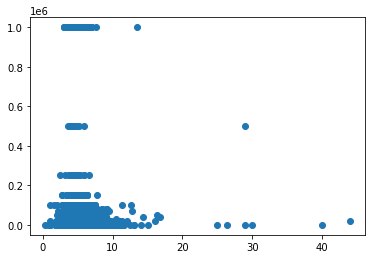

In [119]:
plt.scatter(question_1_data['essay0_avg_word_length'], question_1_data['income'])

In [73]:
# predict orientation based on frequency of I/me in essay0, length of essay0, essay5 avg word length, essay5 length

question_2_data = alldata.dropna(subset = ['drinks_num_scale', 'smokes_num_scale', 'drugs_num_scale', \
                                           'sex_binary', 'orientation'])
#question_1_data = alldata.dropna(subset = ['age','sex_binary','drinks_num_scale','drugs_num_scale','smokes_num_scale',\
#                                           'essay0_avg_word_length', 'essay1_avg_word_length', 'essay2_avg_word_length', \
#                                           'essay6_length', 'education'])


question_2_data = question_2_data[question_2_data.essay0_length != 0.0]
#question_2_data = question_2_data[question_2_data.essay1_length != 0.0]
question_2_data = question_2_data[question_2_data.essay2_length != 0.0]
question_2_data = question_2_data[question_2_data.essay5_length != 0.0]
#question_2_data = question_2_data[question_2_data.essay6_length != 0.0]

question_2_data["orientation_trinary"] = question_2_data.orientation.map({"straight": 0, "gay": 1, "bisexual": 2})

print(question_2_data.info())

#predict_orientation_data = question_2_data[['essay0_i_me_count','essay0_you_count','essay0_avg_word_length', \
#                                            'essay1_avg_word_length', 'essay2_avg_word_length', \
#                                            'essay5_avg_word_length', 'essay6_avg_word_length']]
predict_orientation_data = question_2_data[['essay0_i_me_count','essay0_length', \
                                            'essay2_length', 'essay5_length', \
                                            'sex_binary','drinks_num_scale', 'smokes_num_scale', \
                                            'drugs_num_scale']]
predict_orientation_labels = question_2_data['orientation']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31301 entries, 0 to 59943
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     31301 non-null  int64  
 1   sex                     31301 non-null  object 
 2   sex_binary              31301 non-null  int64  
 3   orientation             31301 non-null  object 
 4   status                  31301 non-null  object 
 5   offspring               13681 non-null  object 
 6   drinks_num_scale        31301 non-null  float64
 7   drugs_num_scale         31301 non-null  float64
 8   smokes_num_scale        31301 non-null  float64
 9   education               28988 non-null  object 
 10  income                  31301 non-null  int64  
 11  job                     28578 non-null  object 
 12  essay0_length           31301 non-null  int64  
 13  essay0_avg_word_length  31301 non-null  float64
 14  essay0_i_me_count       31301 non-null

In [80]:
feat_train_q2, feat_test_q2, labels_train_q2, labels_test_q2 =  \
      train_test_split(predict_orientation_data, predict_orientation_labels, \
                       train_size = 0.8, test_size = 0.2, random_state = 7)

In [81]:
stdscale2 = StandardScaler()
stdscale2.fit_transform(feat_train_q2)
stdscale2.fit_transform(feat_test_q2)

array([[-0.4167371 , -0.34129476, -0.56832946, ...,  0.19159403,
        -0.40748045,  0.47358872],
       [ 1.99328295,  1.25936381,  0.21895315, ...,  0.19159403,
        -0.40748045,  0.47358872],
       [ 0.44398435,  0.47467151, -0.17960867, ..., -1.15472497,
        -0.40748045,  0.47358872],
       ...,
       [-0.4167371 , -0.74217017, -0.30262158, ...,  0.19159403,
        -0.40748045,  0.47358872],
       [-0.07244852, -0.33418704, -0.59293204, ...,  0.19159403,
        -0.40748045,  0.47358872],
       [-0.24459281, -0.42374431, -0.53388584, ..., -2.50104396,
        -0.40748045,  0.47358872]])

In [84]:
scores = []
gees = []
cees = []

for g in range(1,5):
    for c in range(1,11):
        c = c / 10.0
        classes = SVC(kernel = 'rbf', gamma = g, C = c, max_iter = 300)
        classes.fit(feat_train_q2, labels_train_q2)
        scores.append(classes.score(feat_test_q2,labels_test_q2))
        gees.append(g)
        cees.append(c)

c:\users\mcale\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
c:\users\mcale\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
c:\users\mcale\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
c:\users\mcale\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated ear

c:\users\mcale\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
c:\users\mcale\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
c:\users\mcale\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
c:\users\mcale\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated ear

In [85]:
print(scores.index(max(scores)), max(scores))
print(gees[8])
print(cees[8])

1 0.853378054623862
1
0.9


In [76]:
scores_knn_q2 = []

for k in range(1,301):
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(feat_train_q2, labels_train_q2)
    scores_knn_q2.append(classifier.score(feat_test_q2, labels_test_q2))
    
print(scores_knn_q2.index(max(scores_knn_q2))+1)

18


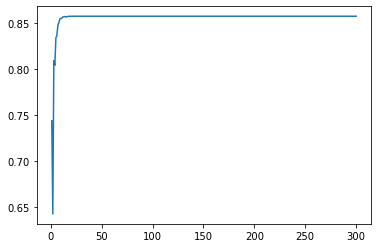

In [77]:
plt.plot(range(1,301),scores_knn_q2)
#plt.axis([80,100,0.8,1.0])

In [ ]:
knn_classifier2 = KNeighborsClassifier(n_neighbors = scores_knn_q2.index(max(scores_knn_q2))+1)
knn_classifier2.fit(feat_train_q2, labels_train_q2)

knn_labels_predictions2 = knn_classifier2.predict(feat_test_q2)
knn_classifier_score2 = knn_classifier2.score(feat_test_q2, labels_test_q2)
print(knn_classifier_score2)

In [49]:
scores_kmeans_q2 = []

for k in range(1,51):
    classifier = KMeans(n_clusters=k, init='k-means++', max_iter=300)
    classifier.fit(feat_train_q1, labels_train_q1)
    scores_kmeans_q1.append(classifier.score(feat_test_q1, labels_test_q1))
    
print(scores_kmeans_q1.index(max(scores_kmeans_q1))+1)

49


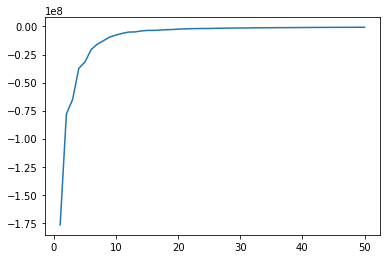

In [50]:
plt.plot(range(1,51),scores_kmeans_q1)

In [ ]:
# Dis didn't work but I's keepin it:
# get all non-zero word lists for all essays, and the sexes associated with them
# then add the lists together

master_words_list = []
master_sexes_list = []
master_orientation_list = []

for i in range(len(essay0_words_list)):
    thislist = essay0_words_list[i]
    thissex = profiles.sex[i]
    thisorientation = profiles.orientation[i]
    if profiles.essay0_length[i] > 0:
        for word in thislist:
            master_words_list.append(word)
            master_sexes_list.append(thissex)
            master_orientation_list.append(thisorientation)

#for i in range(len(essay1_words_list)):
#    thislist = essay1_words_list[i]
#    thissex = profiles.sex[i]
#    thisorientation = profiles.orientation[i]
#    if profiles.essay1_length[i] > 0:
#        for word in thislist:
#            master_words_list.append(word)
#            master_sexes_list.append(thissex)
#            master_orientation_list.append(thisorientation)

#for i in range(len(essay2_words_list)):
#    thislist = essay2_words_list[i]
#    thissex = profiles.sex[i]
#    thisorientation = profiles.orientation[i]
#    if profiles.essay2_length[i] > 0:
#        for word in thislist:
#            master_words_list.append(word)
#            master_sexes_list.append(thissex)
#            master_orientation_list.append(thisorientation)
        
#for i in range(len(essay5_words_list)):
#    thislist = essay5_words_list[i]
#    thissex = profiles.sex[i]
#    thisorientation = profiles.orientation[i]
#    if profiles.essay5_length[i] > 0:
#        for word in thislist:
#            master_words_list.append(word)
#            master_sexes_list.append(thissex)
#            master_orientation_list.append(thisorientation)
        
#for i in range(len(essay6_words_list)):
#    thislist = essay6_words_list[i]
#    thissex = profiles.sex[i]
#    thisorientation = profiles.orientation[i]
#    if profiles.essay6_length[i] > 0:
#        for word in thislist:
#            master_words_list.append(word)
#            master_sexes_list.append(thissex)
#            master_orientation_list.append(thisorientation)
            
print(len(master_words_list), len(master_sexes_list), len(master_orientation_list))